In [1]:
# Cellule 1 – Imports, GPU, config, chemins

# ============================================================
# Notebook 05 — BoneAge Regression V13 (preprocessed_v3)
# Deux phases : Head → Fine-tuning partiel (40 couches)
# ============================================================

import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.utils.class_weight import compute_sample_weight

from tensorflow.keras import layers, models, callbacks, mixed_precision, Input
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.optimizers import AdamW

# ----------------- Seed & GPU -----------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Seed global fixé à 42.")

print("\n--- Configuration GPU et Mixed Precision ---")
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)
print("Politique de précision mixte :", mixed_precision.global_policy())

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU détecté ({len(gpus)}) — croissance mémoire activée.")
else:
    print("Aucun GPU détecté → CPU")

print("TensorFlow:", tf.__version__)

# ----------------- Paramètres globaux -----------------
IMG_SIZE = 300
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

BASE_DIR = Path(".")  # Notebook lancé depuis le dossier Boneage

# Dossier des images prétraitées (preprocessed_v3)
PREPROC_DIR = BASE_DIR / "preprocessed_v3"

# CSV v3
TRAIN_CSV = BASE_DIR / "boneage_train_final_v3.csv"
VAL_CSV   = BASE_DIR / "boneage_val_v3.csv"
TEST_CSV  = BASE_DIR / "boneage_test_v3.csv"

# Noms de sortie pour V13
FINETUNED_WEIGHTS_PATH = "best_finetuned_v13_preproc_v3.weights.h5"
MODEL_V13_PATH         = "model_v13_preproc_v3.keras"

print("\n=== MODE V13_preprocessed_v3 ===")
print("Images prétraitées :", PREPROC_DIR)
print("Train CSV :", TRAIN_CSV)
print("Val   CSV :", VAL_CSV)
print("Test  CSV :", TEST_CSV)
print("Poids fine-tuned :", FINETUNED_WEIGHTS_PATH)
print("Modèle complet :", MODEL_V13_PATH)


2025-11-30 16:58:51.455704: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 16:58:51.544815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 16:58:51.568909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 16:58:51.576124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 16:58:51.660607: I tensorflow/core/platform/cpu_feature_guar

Seed global fixé à 42.

--- Configuration GPU et Mixed Precision ---
Politique de précision mixte : <DTypePolicy "mixed_float16">
GPU détecté (1) — croissance mémoire activée.
TensorFlow: 2.17.0

=== MODE V13_preprocessed_v3 ===
Images prétraitées : preprocessed_v3
Train CSV : boneage_train_final_v3.csv
Val   CSV : boneage_val_v3.csv
Test  CSV : boneage_test_v3.csv
Poids fine-tuned : best_finetuned_v13_preproc_v3.weights.h5
Modèle complet : model_v13_preproc_v3.keras


I0000 00:00:1764521934.821837   96768 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764521935.162758   96768 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764521935.162854   96768 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Cellule 2 – Chargement des DataFrames + préparation des chemins

# ============================================================
# CELLULE 2 — DataFrames (V13, images prétraitées)
# ============================================================

def prepare_dataframe(df, images_dir: Path):
    # On suppose que l'ID correspond à <id>.png dans preprocessed_v3
    df = df.copy()
    df["image_path"] = df["id"].apply(lambda x: str(images_dir / f"{x}.png"))
    # On filtre les lignes dont l'image n'existe pas
    df = df[df["image_path"].apply(lambda x: Path(x).exists())]
    df["male"]  = df["male"].astype(np.float32)
    df["label"] = df["boneage"].astype(np.float32)
    return df

print("\n--- Chargement des CSV ---")
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)

train_df = prepare_dataframe(train_df, PREPROC_DIR)
val_df   = prepare_dataframe(val_df, PREPROC_DIR)
test_df  = prepare_dataframe(test_df, PREPROC_DIR)

# Sample weights (équilibrage sur 'male')
sample_weights = compute_sample_weight(class_weight="balanced",
                                       y=train_df["male"])
train_df["sample_weight"] = sample_weights
val_df["sample_weight"]   = 1.0
test_df["sample_weight"]  = 1.0

print(f"Train : {len(train_df)}  |  Val : {len(val_df)}  |  Test : {len(test_df)}")
print("Exemple de lignes train_df :")
train_df.head()



--- Chargement des CSV ---
Train : 7701  |  Val : 1359  |  Test : 2265
Exemple de lignes train_df :


,id,boneage,male,age_bin,strata,image_path,label,sample_weight
0,12380,156,1.0,144-161,True_144-161,preprocessed_v3/12380.png,156.0,0.927608
1,9535,120,0.0,108-125,False_108-125,preprocessed_v3/9535.png,120.0,1.084648
2,12319,106,0.0,90-107,False_90-107,preprocessed_v3/12319.png,106.0,1.084648
3,10433,94,0.0,90-107,False_90-107,preprocessed_v3/10433.png,94.0,1.084648
4,9223,82,0.0,72-89,False_72-89,preprocessed_v3/9223.png,82.0,1.084648


In [3]:
# ============================================================
# CELLULE 3 — Pipelines TF (V13, préprocessed_v3, augmentations allégées)
# ============================================================

print("\n--- Construction Pipeline TF (V13_preprocessed_v3) ---")

# Augmentations allégées (V13)
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),

        # Allégées
        layers.RandomRotation(0.10),        # ±10%
        layers.RandomTranslation(0.10, 0.10),
        layers.RandomZoom(0.10),
        layers.RandomBrightness(0.20),
        layers.RandomContrast(0.20),
        layers.GaussianNoise(0.03),

        # Suppression de RandomCrop (trop destructeur)
        # Suppression du resize forcé avant crop

        # ✔ Resize final (toujours)
        layers.Resizing(IMG_SIZE, IMG_SIZE),

        # Petite rotation résiduelle
        layers.RandomRotation(factor=0.01)
    ],
    name="data_augmentation_v13_light"
)

def load_and_preprocess(path, sex, label, augment=False):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(img_bytes, channels=1)
    img = tf.image.grayscale_to_rgb(img)

    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    if augment:
        img = data_augmentation(img, training=True)

    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)

    sex = tf.reshape(tf.cast(sex, tf.float32), (1,))
    label = tf.reshape(tf.cast(label, tf.float32), (1,))

    return {"image_input": img, "sex_input": sex}, label

def create_dataset(df, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (
            df["image_path"].values,
            df["male"].values,
            df["label"].values,
            df["sample_weight"].values
        )
    )

    if shuffle:
        ds = ds.shuffle(len(df), reshuffle_each_iteration=True)

    ds = ds.map(
        lambda p, s, l, w: (*load_and_preprocess(p, s, l, augment), w),
        num_parallel_calls=AUTOTUNE
    )

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = create_dataset(train_df, shuffle=True, augment=True)
val_ds   = create_dataset(val_df,   shuffle=False, augment=False)
test_ds  = create_dataset(test_df,  shuffle=False, augment=False)

print("Pipelines V13_preprocessed_v3 prêts.")



--- Construction Pipeline TF (V13_preprocessed_v3) ---


I0000 00:00:1764521935.338867   96768 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764521935.339004   96768 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764521935.339034   96768 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764521935.681404   96768 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764521935.681553   96768 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-30

Pipelines V13_preprocessed_v3 prêts.


In [4]:
# Cellule 4 – Construction du modèle (backbone + tête)

# ============================================================
# CELLULE 4 — Construction du modèle V13
# ============================================================

print("\n--- Construction du modèle V13 (EfficientNetV2B3) ---")

# Backbone EfficientNetV2B3
base_model = EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Geler les BatchNorm (ON LES LAISSE TOUJOURS GELÉS)
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Phase 1 : HEAD uniquement → backbone gelé
base_model.trainable = False

# Inputs
image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
sex_input   = Input(shape=(1,), name="sex_input")

# Tête du modèle
x = base_model(image_input, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.concatenate([x, sex_input])

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization(trainable=False)(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)

output = layers.Dense(1, dtype="float32")(x)

model = models.Model(
    inputs=[image_input, sex_input],
    outputs=output,
    name="boneage_regression_v13_preprocessed_v3"
)

# Compilation phase 1 (HEAD)
optimizer_head = AdamW(learning_rate=1e-3)

model.compile(
    optimizer=optimizer_head,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

print("\nRésumé du modèle V13 (phase HEAD) :")
model.summary()



--- Construction du modèle V13 (EfficientNetV2B3) ---


2025-11-30 16:58:56.803748: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.



Résumé du modèle V13 (phase HEAD) :


Model: "boneage_regression_v13_preprocessed_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b3   │ (None, 10, 10,    │ 12,930,622 │ image_input[0][0] │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1536)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sex_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1537)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ sex_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    393,728 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,358,399 (50.96 MB)

 Trainable params: 426,753 (1.63 MB)

 Non-trainable params: 12,931,646 (49.33 MB)

In [5]:
# Cellule 5 – Phase 1 : entraînement de la tête uniquement

# ============================================================
# CELLULE 5 — Phase 1 : Entraînement de la tête (backbone gelé)
# ============================================================

print("\n--- Phase 1 : Entraînement de la tête (backbone gelé) ---")

EPOCHS_HEAD = 5  # suffisant pour stabiliser la tête

callbacks_head = [
    callbacks.EarlyStopping(
        monitor="val_mean_absolute_error",
        patience=3,
        restore_best_weights=True,
        mode="min",
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_mean_absolute_error",
        factor=0.3,
        patience=2,
        min_lr=1e-5,
        mode="min",
        verbose=1
    )
]

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks_head
)

print("Phase 1 terminée.")



--- Phase 1 : Entraînement de la tête (backbone gelé) ---
Epoch 1/5


I0000 00:00:1764521947.384599   96837 service.cc:146] XLA service 0x77baa4003160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764521947.384627   96837 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-30 16:59:07.870963: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 16:59:09.227933: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 91200
I0000 00:00:1764521963.661271   96837 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


963/963 ━━━━━━━━━━━━━━━━━━━━ 118s 94ms/step - loss: 25.6588 - mean_absolute_error: 25.7057 - val_loss: 17.4681 - val_mean_absolute_error: 17.4681 - learning_rate: 0.0010
Epoch 2/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - loss: 20.9713 - mean_absolute_error: 20.9981 - val_loss: 22.0480 - val_mean_absolute_error: 22.0480 - learning_rate: 0.0010
Epoch 3/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 20.8764 - mean_absolute_error: 20.9326
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
963/963 ━━━━━━━━━━━━━━━━━━━━ 60s 62ms/step - loss: 20.7283 - mean_absolute_error: 20.7311 - val_loss: 19.0410 - val_mean_absolute_error: 19.0410 - learning_rate: 0.0010
Epoch 4/5
963/963 ━━━━━━━━━━━━━━━━━━━━ 61s 64ms/step - loss: 19.4809 - mean_absolute_error: 19.4750 - val_loss: 19.8073 - val_mean_absolute_error: 19.8073 - learning_rate: 3.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Phase 1 terminée.


In [6]:
# ============================================================
# CELLULE 6 — Fine-tuning progressif (V13)
# ============================================================

print("\n--- Phase 2 : Fine-tuning progressif (V13) ---")

def unfreeze_last_n_layers(model, n):
    total = len(model.layers)
    cutoff = total - n
    for i, layer in enumerate(model.layers):
        if i < cutoff:
            layer.trainable = False
        else:
            # Les BatchNorm restent gelées
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False
            else:
                layer.trainable = True
    print(f"→ {n} couches dégelées ({cutoff} → {total-1})")

# ============== Etape 1 : unfreeze léger (5 couches) ==============
unfreeze_last_n_layers(base_model, 5)

optimizer_ft = AdamW(learning_rate=1e-5)

model.compile(
    optimizer=optimizer_ft,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

print("\n[FT1] Entraînement avec 5 couches dégelées...")
history_ft1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    verbose=1
)

# ============== Etape 2 : unfreeze moyen (15 couches) ==============
unfreeze_last_n_layers(base_model, 15)

optimizer_ft = AdamW(learning_rate=7e-6)
model.compile(
    optimizer=optimizer_ft,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

print("\n[FT2] Entraînement avec 15 couches dégelées...")
history_ft2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    verbose=1
)

# ============== Etape 3 : unfreeze profond (40 couches) ==============
unfreeze_last_n_layers(base_model, 40)

optimizer_ft = AdamW(learning_rate=5e-6)
model.compile(
    optimizer=optimizer_ft,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

callbacks_final = [
    callbacks.EarlyStopping(
        monitor="val_mean_absolute_error",
        patience=5,
        restore_best_weights=True,
        mode="min",
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_mean_absolute_error",
        factor=0.3,
        patience=2,
        min_lr=1e-7,
        mode="min",
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=FINETUNED_WEIGHTS_PATH,
        monitor="val_mean_absolute_error",
        save_weights_only=True,
        save_best_only=True,
        mode="min",
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=MODEL_V13_PATH,
        monitor="val_mean_absolute_error",
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        verbose=1
    )
]

print("\n[FT3] Entraînement avec 40 couches dégelées...")
history_ft3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_final,
    verbose=1
)

print("\nFine-tuning progressif terminé.")



--- Phase 2 : Fine-tuning progressif (V13) ---
→ 5 couches dégelées (404 → 408)

[FT1] Entraînement avec 5 couches dégelées...
Epoch 1/3
963/963 ━━━━━━━━━━━━━━━━━━━━ 108s 87ms/step - loss: 20.4258 - mean_absolute_error: 20.4417 - val_loss: 18.9977 - val_mean_absolute_error: 18.9977
Epoch 2/3
963/963 ━━━━━━━━━━━━━━━━━━━━ 99s 58ms/step - loss: 20.2104 - mean_absolute_error: 20.1991 - val_loss: 18.6112 - val_mean_absolute_error: 18.6112
Epoch 3/3
963/963 ━━━━━━━━━━━━━━━━━━━━ 61s 63ms/step - loss: 19.7308 - mean_absolute_error: 19.7370 - val_loss: 17.3359 - val_mean_absolute_error: 17.3359
→ 15 couches dégelées (394 → 408)

[FT2] Entraînement avec 15 couches dégelées...
Epoch 1/3
963/963 ━━━━━━━━━━━━━━━━━━━━ 115s 91ms/step - loss: 19.6537 - mean_absolute_error: 19.6814 - val_loss: 16.0928 - val_mean_absolute_error: 16.0928
Epoch 2/3
963/963 ━━━━━━━━━━━━━━━━━━━━ 62s 65ms/step - loss: 19.1568 - mean_absolute_error: 19.1678 - val_loss: 15.6609 - val_mean_absolute_error: 15.6609
Epoch 3/3
963

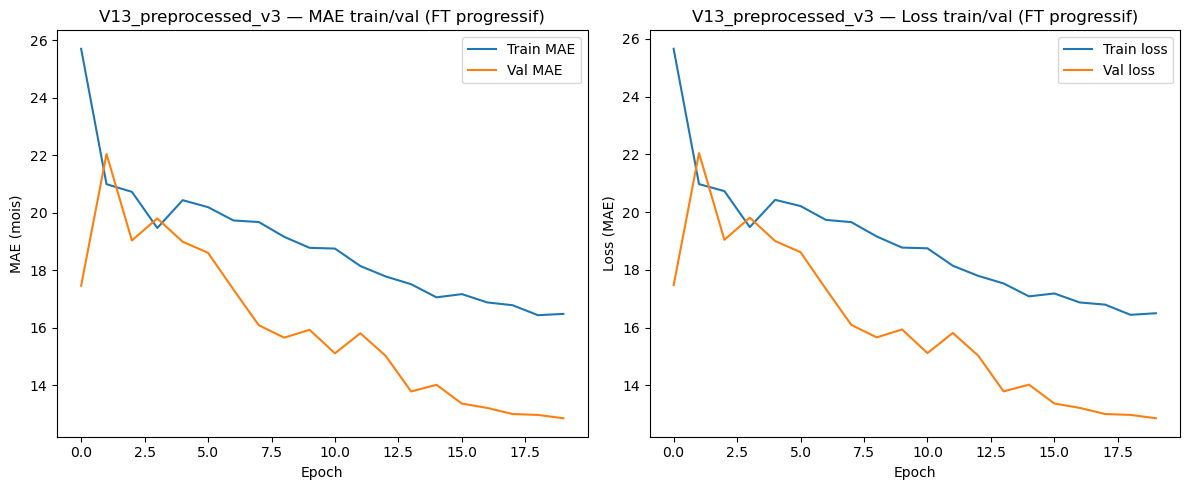

In [7]:
# ============================================================
# CELLULE 7 — Courbes d'apprentissage (V13, FT progressif)
# ============================================================

def merge_histories(*histories):
    merged = {}
    for h in histories:
        for k, v in h.history.items():
            merged.setdefault(k, []).extend(v)
    return merged

history_combined = merge_histories(history_head, history_ft1, history_ft2, history_ft3)

plt.figure(figsize=(12, 5))

# MAE
plt.subplot(1, 2, 1)
plt.plot(history_combined["mean_absolute_error"], label="Train MAE")
plt.plot(history_combined["val_mean_absolute_error"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE (mois)")
plt.title("V13_preprocessed_v3 — MAE train/val (FT progressif)")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_combined["loss"], label="Train loss")
plt.plot(history_combined["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.title("V13_preprocessed_v3 — Loss train/val (FT progressif)")
plt.legend()

plt.tight_layout()
plt.show()



--- Évaluation finale du modèle V13_preprocessed_v3 ---
Poids V13 chargés : best_finetuned_v13_preproc_v3.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 12.3101 - mean_absolute_error: 12.3101

MAE test (Keras) : 12.310 mois

Calcul des prédictions et du R² sur le test ...
284/284 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step
R² sur le test : 0.839


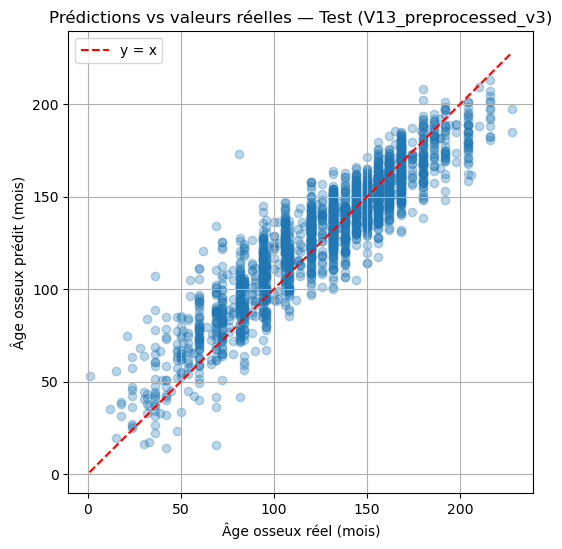

In [8]:
# Cellule 8 – Évaluation finale sur le test

print("\n--- Évaluation finale du modèle V13_preprocessed_v3 ---")

# Charger les meilleurs poids sauvegardés
model.load_weights(FINETUNED_WEIGHTS_PATH)
print(f"Poids V13 chargés : {FINETUNED_WEIGHTS_PATH}")

# 1) MAE test (via Keras)
test_loss, test_mae = model.evaluate(test_ds, verbose=1)
print(f"\nMAE test (Keras) : {test_mae:.3f} mois")

# 2) Prédictions + R²
print("\nCalcul des prédictions et du R² sur le test ...")
y_true = test_df["label"].values
y_pred = model.predict(test_ds).flatten()

r2 = r2_score(y_true, y_pred)
print(f"R² sur le test : {r2:.3f}")

# 3) Scatterplot True vs Pred
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    "r--",
    label="y = x"
)

plt.xlabel("Âge osseux réel (mois)")
plt.ylabel("Âge osseux prédit (mois)")
plt.title("Prédictions vs valeurs réelles — Test (V13_preprocessed_v3)")
plt.legend()
plt.grid(True)
plt.show()
